# Dask geopandas example
In this example, we will use Finnish addresses (osoitteet), and based on post codes data, we will assign each address its post code.

### Dask client
Create your Dask Cluster and paste address of your scheduler here.

Tip: click Launch dashboard in JupyterLab to see Dask dashboards.

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40053")
client

<Client: 'tcp://127.0.0.1:40053' processes=3 threads=6, memory=30.00 GiB>

## Import datasets
We are using two datasets:
- **[Post codes dataset.](http://urn.fi/urn:nbn:fi:att:0039add2-7b4f-49fe-9c7b-03eaa4ec67b1)** It contains data about all Finnish post code areas, and thier geometry, saved as polygons. `Postinumer` attribute contains post code numbers. 
- **[Finnish addresses dataset.](http://urn.fi/urn:nbn:fi:att:e5acb8cc-a8b9-41f6-b6bc-d98cab22f80e)** This is a point dataset, that contains all addresses in Finland.  

Both datasets are shapefiles, so we will use the dask-geopandas read_file function to read the data to a Dask's GeoDataFrame. Dask GeoDataFrame (or DataFrame in general) is internally split into many partitions, where each partition is a GeoPandas DataFrame (or Pandas DataFrame) that contains only part of the data. Common strategies to partition Dask DataFrames include using a fixed number of partitions or partitions based on column values. In this case, we will use the first method and divide the dataset into four parts (`npartitions=4`). It is a good practice to keep the partition size below 1GB.

In [2]:
import dask_geopandas
import pandas as pd
import geopandas as gpd

#### Post codes

In [3]:
post_codes_dataset_path = "/appl/data/geo/tilastokeskus/paavo/2023"
post_codes = dask_geopandas.read_file(post_codes_dataset_path, npartitions=4)

In [4]:
post_codes = post_codes[["postinumer", "geometry"]]
post_codes.head()

,postinumer,geometry
0,00100,"POLYGON ((385653.893 6671591.048, 385573.619 6..."
1,00120,"POLYGON ((385316.092 6671076.984, 385279.611 6..."
2,00130,"POLYGON ((386212.111 6671061.262, 386176.826 6..."
3,00140,"MULTIPOLYGON (((386577.050 6670280.544, 386552..."
4,00150,"MULTIPOLYGON (((384846.102 6669565.816, 384823..."


#### Addresses

In [5]:
%%time
addresses_dataset_path = "/appl/data/geo/dvv/osoitteet/2022"
addresses_dataset = dask_geopandas.read_file(addresses_dataset_path, npartitions=4)

CPU times: user 23.5 ms, sys: 36.3 ms, total: 59.9 ms
Wall time: 60.7 ms


In [6]:
addresses_dataset.head()

,rakennustu,sijaintiku,sijaintima,rakennusty,osoitenume,katunimi_f,katunimi_s,katunumero,postinumer,aanestysal,aan_al_fi,aan_al_se,kiinteisto,geometry
0,100085724R,None,None,2,None,None,None,None,25830,None,None,None,92300000000000,POINT (263348.000 6665828.000)
1,100170063B,None,None,1,None,None,None,None,34550,None,None,None,None,POINT (314047.000 6886624.000)
2,100170070K,None,None,2,None,None,None,None,34550,None,None,None,None,POINT (307656.000 6891898.000)
3,100170071L,None,None,1,None,None,None,None,39700,None,None,None,None,POINT (307790.000 6874060.000)
4,100170072M,None,None,1,None,None,None,None,39700,None,None,None,None,POINT (307974.000 6873931.000)


### Add index
Let's add an index to the addresses dataset, so later we can check if postal codes are correct. To find the total number of rows in DataFrame, we use the `shape` attribute. Dask does not compute the results immediately. Instead, it creates a graph of tasks and adds new operations to it. If we want to see the result, we have to call the `compute` method on our DataFrame. After calling `compute`, the entire graph is computed. If we do not do that, we are left with a `delayed` object.

In [7]:
number_of_rows = addresses_dataset.shape[0]
number_of_rows

Delayed('int-202b8885-a41f-4a83-8ade-ef15c9b9463b')

#### Visualize graph
Before we compute the result, we will visualize Dask-GeoDataFrame's tasks graph by calling the `visualize` method.

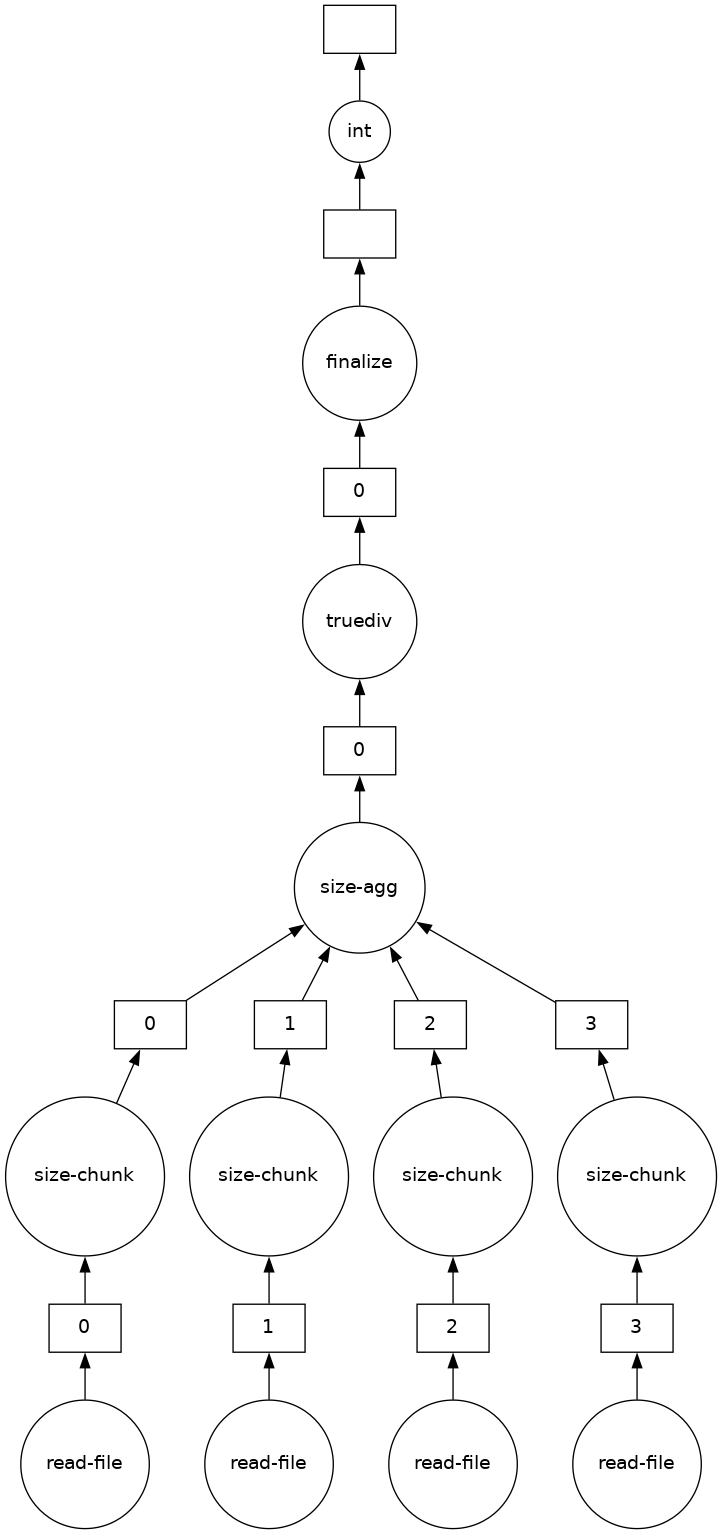

In [8]:
number_of_rows.visualize()

As we can see, we have four read-file tasks, since we have 4 partitions. Data from all partitions have to be loaded and aggregated before calculating the total number of rows. Now, let's compute this graph and use it to create an index column.

In [9]:
number_of_rows = number_of_rows.compute()
number_of_rows

3794622

In [10]:
addresses_dataset["id"] = pd.Series(range(number_of_rows))
addresses_dataset.set_index("id")
addresses_dataset.head()

,rakennustu,sijaintiku,sijaintima,rakennusty,osoitenume,katunimi_f,katunimi_s,katunumero,postinumer,aanestysal,aan_al_fi,aan_al_se,kiinteisto,geometry,id
0,100085724R,None,None,2,None,None,None,None,25830,None,None,None,92300000000000,POINT (263348.000 6665828.000),0
1,100170063B,None,None,1,None,None,None,None,34550,None,None,None,None,POINT (314047.000 6886624.000),1
2,100170070K,None,None,2,None,None,None,None,34550,None,None,None,None,POINT (307656.000 6891898.000),2
3,100170071L,None,None,1,None,None,None,None,39700,None,None,None,None,POINT (307790.000 6874060.000),3
4,100170072M,None,None,1,None,None,None,None,39700,None,None,None,None,POINT (307974.000 6873931.000),4


#### Clean up
Before adding post codes to addresses, let's create new DataFrame without unnessesery columns. In this case, we only care about geometry and index.

In [11]:
addresses = addresses_dataset[["geometry", "id"]]

## Join address points with post codes
To add post codes to addresses, we perform the spatial join. We assign a row from the `post_code` DataFrame to every row from the DataFrame `addresses`, based on the intersection of their geometries. Again, we check the tasks graph and call the `compute` method to get the result.

Note: `how="inner", predicate="intersects"` are the only supported methods at the moment.

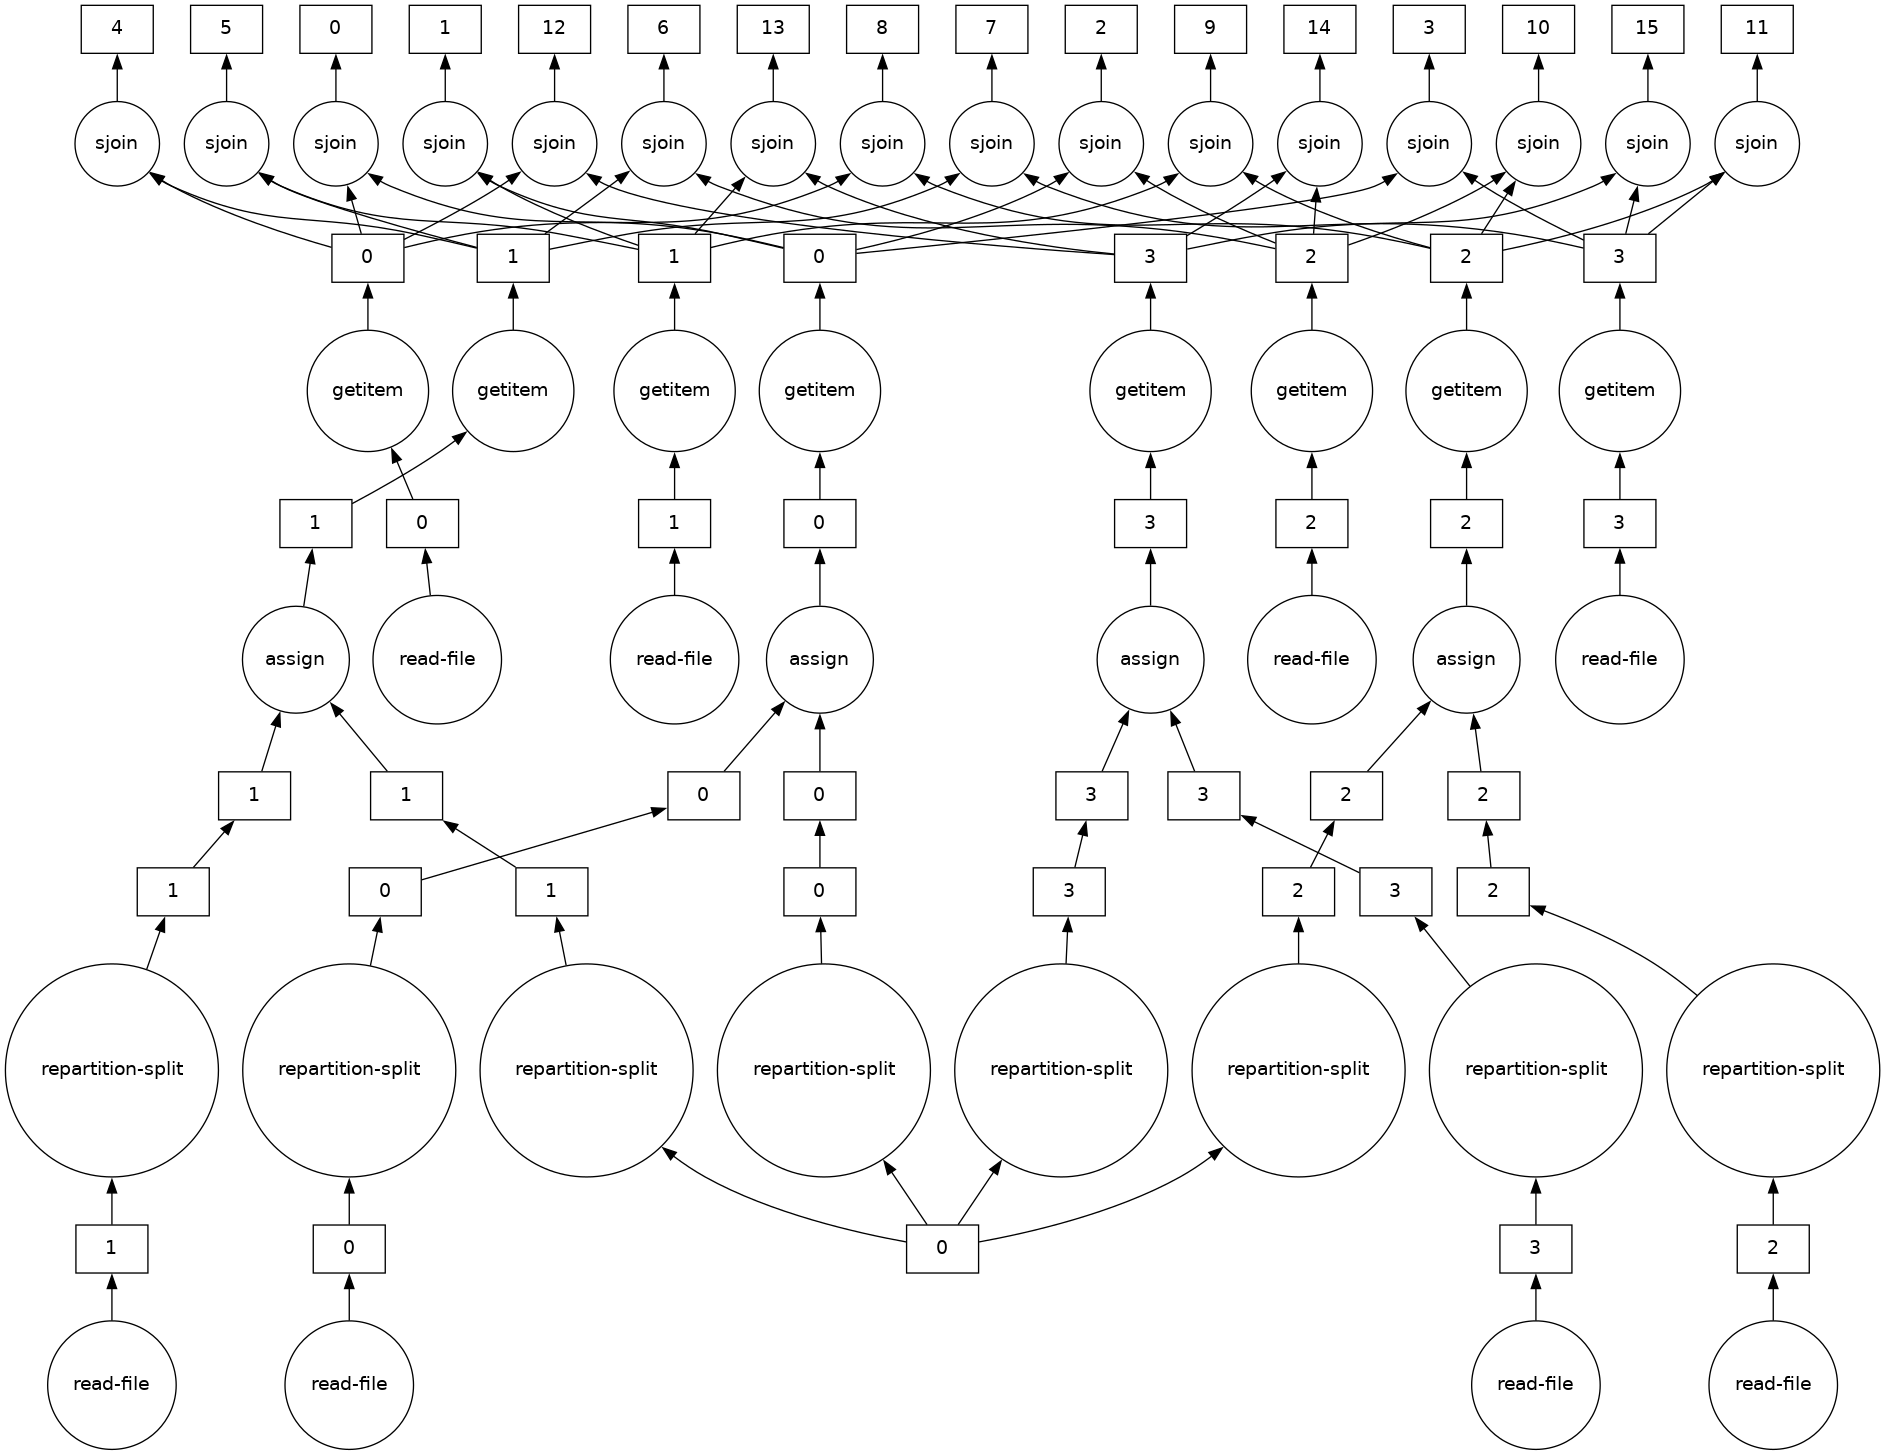

In [12]:
addresses_post = addresses.sjoin(post_codes, how="inner", predicate="intersects")
addresses_post.visualize()

Again, we can see that after calling compute, Dask will load data (this time 8 times since we have to load post codes dataset as well) and then perform the spatial join.

In [13]:
%%time
addresses_post = addresses_post.compute()

CPU times: user 2.6 s, sys: 362 ms, total: 2.97 s
Wall time: 30 s


In [14]:
addresses_post.head()

,geometry,id,index_right,postinumer
18,POINT (331449.000 6728026.000),18,212,03850
19,POINT (331157.000 6727452.000),19,212,03850
20,POINT (331139.000 6727476.000),20,212,03850
65,POINT (181142.000 6714455.000),65,718,23390
66,POINT (188591.000 6706941.000),66,718,23390


#### Warning!
Notice that after the last compute, the `addresses_post` DataFrame is no longer Dask-GeoDataFrame, but a regular GeoDataFrame. It is up to the user to make sure that the result of the compute will fit into the memory. [Read more](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.compute.html)

In [15]:
type(addresses_post)

geopandas.geodataframe.GeoDataFrame

## Validate results
Let's check if the assigned post codes are the same as in the attribute `postinumer` from the addresses dataset. We rename columns so we know which column is the one that we assigned and which one is the original one. Next, we merge two DataFrames, and by looking at the resulting DataFrame `validate` we can tell that we correclty assigned post codes to a addresses. Before merging, we have to convert the original dataset from dask GeoDataFrame to pandas GeoDataFrame. We can easliy do it by calling `compute` method on a dask GeoDataFrame.

In [16]:
addresses_check = addresses_dataset[["id", "postinumer"]]
addresses_check = addresses_check.compute()

In [17]:
addresses_check = addresses_check.rename(columns={"postinumer": "original_postinumer"})
addresses_post = addresses_post.rename(columns={"postinumer": "assigned_postinumer"})

In [18]:
validate = addresses_post.merge(addresses_check, on="id")
validate

,geometry,id,index_right,assigned_postinumer,original_postinumer
0,POINT (331449.000 6728026.000),18,212,03850,03850
1,POINT (331157.000 6727452.000),19,212,03850,03850
2,POINT (331139.000 6727476.000),20,212,03850,03850
3,POINT (181142.000 6714455.000),65,718,23390,23390
4,POINT (188591.000 6706941.000),66,718,23390,23390
...,...,...,...,...,...
3749818,POINT (390868.000 7099920.000),3736721,2464,84770,84770
3749819,POINT (390932.000 7100563.000),3736789,2464,84770,84770
3749820,POINT (390676.000 7100016.000),3736792,2464,84770,84770
3749821,POINT (390457.000 7101334.000),3736830,2464,84770,84770


As we can see, the post codes are the same.

## Time comparasion to geopandas
Let's time how long would it take to perform loading data and a spatial join without dask geopandas, only using geopandas. We will read the data again to regular GeoDataFrame, and time loading and sjoin command.

Note: if your JupyterLab does not have enough memory, this can result in your interactive session being killed due to memory being exceeded.

In [19]:
post_codes = gpd.read_file(post_codes_dataset_path)
post_codes = post_codes[["postinumer", "geometry"]]

In [20]:
%%time

addresses_dataset = gpd.read_file(addresses_dataset_path)
addresses = addresses_dataset[["geometry"]]

CPU times: user 2min 1s, sys: 4.21 s, total: 2min 5s
Wall time: 2min 5s


In [21]:
%%time

addresses_post = addresses.sjoin(post_codes, how="inner", predicate="intersects")

CPU times: user 20.7 s, sys: 282 ms, total: 21 s
Wall time: 21 s


In [22]:
addresses_post

,geometry,index_right,postinumer
0,POINT (263348.000 6665828.000),776,25830
1527423,POINT (259315.000 6660945.000),776,25830
1527428,POINT (264032.000 6663440.000),776,25830
1527429,POINT (263402.000 6658453.000),776,25830
1527432,POINT (259539.000 6664419.000),776,25830
...,...,...,...
3794527,POINT (434630.000 6943404.000),1314,44120
3794529,POINT (434477.000 6943255.000),1314,44120
3794536,POINT (434576.000 6943055.000),1314,44120
3794596,POINT (435042.000 6944568.000),1314,44120


### Results
Here are execution times I have got after running this notebook several times.

| command           | Dask-geopandas | geopandas |
| :---------------- | :------------: | --------: |
| read_file         |                |   ± 140s  |
| sjoin             |                |   ± 20s   |
| total             |   ± 29s        |   ± 160s  |

Since Dask uses a tasks graph to collect operations, it is hard to tell how much time read and sjoin take - we only know the total execution time. As we can see, Dask-geopandas was much faster than regular GeoPandas.

## Clean up
We can close the Dask cluster client to make sure the connection has ended.

In [23]:
client.close()